# QF620 Project Part II - Model Calibration

**Group 8**\
Ee Jing Michelle\
Ishani Maitra\
Jermayne Lim Jie Min\
Lim Fang Yi\
Muhammad Saqif Bin Juhaimee\
Rohen S/O Veera Kumaran

# Displaced-Diffusion

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import datetime as dt
import array
from scipy.stats import norm
from scipy.optimize import brentq,fsolve
from scipy import interpolate
from scipy.optimize import least_squares

In [3]:
# Black-Scholes Model
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# Bachelier Model
def BachelierCall(S, K, r, sigma, T):
    d = (S-K) / (S*sigma*np.sqrt(T))
    disc = np.exp(-r*T)
    return disc*((S-K)*norm.cdf(d)+S*sigma*np.sqrt(T)*norm.pdf(d))

def BachelierPut(S, K, r, sigma, T):
    d = (S-K) / (S*sigma*np.sqrt(T))
    disc = np.exp(-r*T)
    return disc*((K-S)*norm.cdf(-d)+S*sigma*np.sqrt(T)*norm.pdf(-d))

In [4]:
# Displaced-Diffusion Model
def DisplacedDiffusionCall(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    return np.exp(-r*T)*(F/beta*norm.cdf(c1) - ((1-beta)/beta*F + K)*norm.cdf(c2))

def DisplacedDiffusionPut(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    return np.exp(-r*T)*(((1-beta)/beta*F + K)*norm.cdf(-c2) - F/beta*norm.cdf(-c1))

In [5]:
from scipy.optimize import minimize

# Objective function for calibration
def calibration_objective(params, strikes, market_vols, S, r, T):
    sigma, beta = params
    model_vols = []

    for K, market_vol in zip(strikes, market_vols):
        if market_vol == market_vol:  # Ensure it's not NaN
            if K <= S:
                model_price = DisplacedDiffusionPut(S, K, r, sigma, T, beta)
                model_vol = impliedPutVolatility(S, K, r, model_price, T)
            else:
                model_price = DisplacedDiffusionCall(S, K, r, sigma, T, beta)
                model_vol = impliedCallVolatility(S, K, r, model_price, T)
            model_vols.append(model_vol)

    # Compute the sum of squared errors
    model_vols = np.array(model_vols)
    market_vols = np.array([v for v in market_vols if v == v])  # Remove NaNs
    errors = model_vols - market_vols
    return np.sum(errors**2)


# 1. SPX Options

In [7]:
# Discount Rate
rate_df = pd.read_csv('zero_rates_20201201.csv')

# SPX General Data
spx_df = pd.read_csv('SPX_options.csv')
spx_df['strike_price'] = spx_df['strike_price']/1000
spx_df['mid_price'] = (spx_df['best_bid'] + spx_df['best_offer'])/2

# SPX Maturity Data
spx1 = spx_df[(spx_df.exdate == 20201218)]
spx2 = spx_df[(spx_df.exdate == 20210115)]
spx3 = spx_df[(spx_df.exdate == 20210219)]

# Time To Maturity
today = dt.date(2020, 12, 1)
exdate1 = dt.date(2020, 12, 18)
exdate2 = dt.date(2021, 1, 15)
exdate3 = dt.date(2021, 2, 19)
T1 = (exdate1-today).days/365.0
T2 = (exdate2-today).days/365.0
T3 = (exdate3-today).days/365.0

# Discount Rate Interpolation
x = rate_df['days']
y = rate_df['rate']
f = interpolate.interp1d(x,y)
r1 = f(T1*365)/100
r2 = f(T2*365)/100
r3 = f(T3*365)/100

# Underlying Value & ATM Strike Price
S = 3662.45
K = 3660

# Beta Parameter (Displaced-Diffusion Model)
# beta1 = 0.8
# beta2 = 0.6
# beta3 = 0.4
# beta4 = 0.2
# 0.1, 0.3, 0.5, 0.7, 0.9, 1.0
#beta1 = 1.0
beta1 = 0.9
beta2 = 0.7
beta3 = 0.5
beta4 = 0.3
beta5 = 0.1

# Steps Parameter (American Options)
steps = 20

In [8]:
# Implied European Options Volatility Model
def impliedCallVolatility(S, K, r, price, T):
    try:
        impliedVol = brentq(lambda x: price -
                        BlackScholesCall(S, K, r, x, T),
                        1e-6, 10)
    except Exception:
        impliedVol = np.nan
    return impliedVol

def impliedPutVolatility(S, K, r, price, T):
    try:
        impliedVol = brentq(lambda x: price -
                        BlackScholesPut(S, K, r, x, T),
                        1e-6, 10)
    except Exception:
        impliedVol = np.nan
    return impliedVol

def impliedVolatility(S, K, r, price, T, option_type):
    try:
        if option_type == 'C':
            return brentq(lambda x: price - BlackScholesCall(S, K, r, x, T), 1e-12, 10)
        else:
            return brentq(lambda x: price - BlackScholesPut(S, K, r, x, T), 1e-12, 10)
    except Exception:
        return np.nan

def calculate_atm_volatility(spx_data, S, K, r, T):
    atm_call = spx_data[(spx_data['strike_price'] == K) & (spx_data['cp_flag'] == 'C')]
    atm_put = spx_data[(spx_data['strike_price'] == K) & (spx_data['cp_flag'] == 'P')]

    if not atm_call.empty and not atm_put.empty:
        sigma_call = impliedVolatility(S, K, r, atm_call.iloc[0]['mid_price'], T, 'C')
        sigma_put = impliedVolatility(S, K, r, atm_put.iloc[0]['mid_price'], T, 'P')
        return (sigma_call + sigma_put) / 2
    else:
        return np.nan

# calculate_atm_volatility
sigma1 = calculate_atm_volatility(spx1, S, K, r1, T1)
sigma2 = calculate_atm_volatility(spx2, S, K, r2, T2)
sigma3 = calculate_atm_volatility(spx3, S, K, r3, T3)

sigma=[sigma1 ,sigma2 ,sigma3 ]
sigma

[0.1750985704585497, 0.18537188428716733, 0.1909732726819407]

### Date1: 18/12/2020

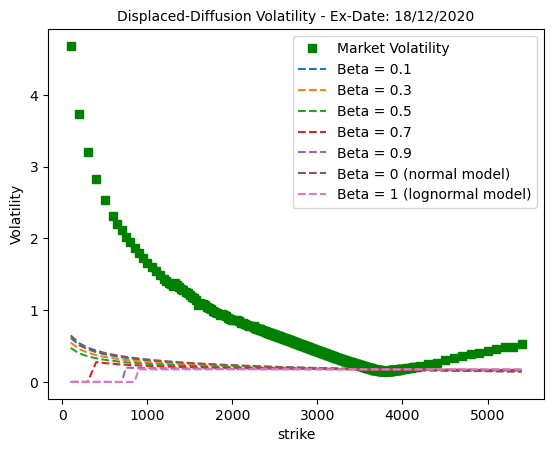

In [10]:
# Displaced Diffusion Volatility (exdate1)

spx_call1 = spx1[(spx1.cp_flag == "C")].reset_index(drop=True)
spx_put1 = spx1[(spx1.cp_flag == "P")].reset_index(drop=True)
strike1 = spx_put1["strike_price"].values

summary1 = []
for i in range(len(spx_put1.index)):
    K = strike1[i]
    if K <= S:
        impliedvol_market = impliedPutVolatility(S, K, r1, spx_put1['mid_price'][i], T1)

        price_lognormal = BlackScholesPut(S, K, r1, sigma1, T1)
        impliedvol_lognormal = impliedPutVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierPut(S, K, r1, sigma1, T1)
        impliedvol_normal = impliedPutVolatility(S, K, r1, price_normal, T1)

        price_dd1 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r1, price_dd1, T1)

        price_dd2 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r1, price_dd2, T1)

        price_dd3 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r1, price_dd3, T1)

        price_dd4 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r1, price_dd4, T1)

        price_dd5 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta5)
        impliedvol_dd5 = impliedPutVolatility(S, K, r1, price_dd5, T1)

    elif K > S:
        impliedvol_market = impliedCallVolatility(S, K, r1, spx_call1['mid_price'][i], T1)

        price_lognormal = BlackScholesCall(S, K, r1, sigma1, T1)
        impliedvol_lognormal = impliedCallVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierCall(S, K, r1, sigma1, T1)
        impliedvol_normal = impliedCallVolatility(S, K, r1, price_normal, T1)

        price_dd1 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r1, price_dd1, T1)

        price_dd2 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r1, price_dd2, T1)

        price_dd3 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r1, price_dd3, T1)

        price_dd4 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r1, price_dd4, T1)

        price_dd5 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta5)
        impliedvol_dd5 = impliedCallVolatility(S, K, r1, price_dd5, T1)

    summary1.append([K,
                    impliedvol_market,
                    impliedvol_lognormal,
                    impliedvol_normal,
                    impliedvol_dd1,
                    impliedvol_dd2,
                    impliedvol_dd3,
                    impliedvol_dd4,
                    impliedvol_dd5
                    ])

dd_1 = pd.DataFrame(summary1, columns=['strike',
                                        'impliedvol_market',
                                        'impliedvol_lognormal',
                                        'impliedvol_normal',
                                        'impliedvol_dd1',
                                        'impliedvol_dd2',
                                        'impliedvol_dd3',
                                        'impliedvol_dd4',
                                        'impliedvol_dd5'
                                        ])
plt.plot(dd_1['strike'], dd_1['impliedvol_market'], 'gs', label = 'Market Volatility')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd5'], label = f'Beta = {beta5}', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd4'], label = f'Beta = {beta4}', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd3'], label = f'Beta = {beta3}', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd2'], label = f'Beta = {beta2}', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd1'], label = f'Beta = {beta1}', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_normal'], label = 'Beta = 0 (normal model)', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_lognormal'], label = 'Beta = 1 (lognormal model)', linestyle = '--')

plt.legend()
plt.title('Displaced-Diffusion Volatility - Ex-Date: 18/12/2020',
          fontsize = 10)
plt.ylabel('Volatility')
plt.show()

### Date2: 15/1/2021

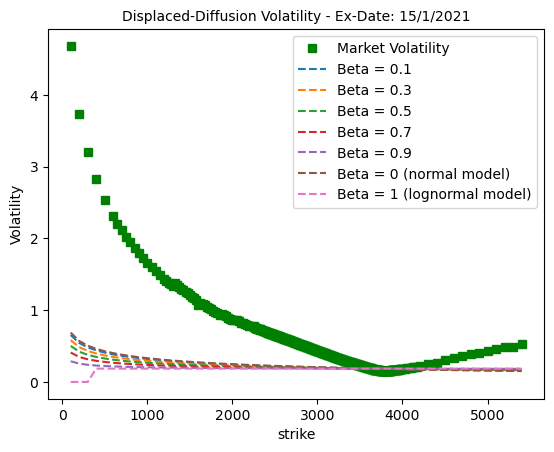

In [12]:
# Displaced Diffusion Volatility (exdate2)
spx_call2 = spx2[(spx2.cp_flag == "C")].reset_index(drop=True)
spx_put2 = spx2[(spx2.cp_flag == "P")].reset_index(drop=True)
strike2 = spx_put2["strike_price"].values

summary2 = []
for i in range(len(spx_put2.index)):
    K = strike2[i]
    if K <= S:
        impliedvol_market = impliedPutVolatility(S, K, r2, spx_put2['mid_price'][i], T2)

        price_lognormal = BlackScholesPut(S, K, r2, sigma2, T2)
        impliedvol_lognormal = impliedPutVolatility(S, K, r2, price_lognormal, T2)

        price_normal = BachelierPut(S, K, r2, sigma2, T2)
        impliedvol_normal = impliedPutVolatility(S, K, r2, price_normal, T2)

        price_dd1 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r2, price_dd1, T2)

        price_dd2 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r2, price_dd2, T2)

        price_dd3 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r2, price_dd3, T2)

        price_dd4 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r2, price_dd4, T2)

        price_dd5 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta5)
        impliedvol_dd5 = impliedPutVolatility(S, K, r2, price_dd5, T2)

    elif K > S:
        impliedvol_market = impliedCallVolatility(S, K, r2, spx_call2['mid_price'][i], T2)

        price_lognormal = BlackScholesCall(S, K, r2, sigma2, T2)
        impliedvol_lognormal = impliedCallVolatility(S, K, r2, price_lognormal, T2)

        price_normal = BachelierCall(S, K, r2, sigma2, T2)
        impliedvol_normal = impliedCallVolatility(S, K, r2, price_normal, T2)

        price_dd1 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r2, price_dd1, T2)

        price_dd2 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r2, price_dd2, T2)

        price_dd3 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r2, price_dd3, T2)

        price_dd4 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r2, price_dd4, T2)

        price_dd5 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta5)
        impliedvol_dd5 = impliedCallVolatility(S, K, r2, price_dd5, T2)

    summary2.append([K,
                     impliedvol_market,
                     impliedvol_lognormal,
                     impliedvol_normal,
                     impliedvol_dd1,
                     impliedvol_dd2,
                     impliedvol_dd3,
                     impliedvol_dd4,
                     impliedvol_dd5])

dd_2 = pd.DataFrame(summary2, columns=['strike',
                                       'impliedvol_market',
                                       'impliedvol_lognormal',
                                       'impliedvol_normal',
                                       'impliedvol_dd1',
                                       'impliedvol_dd2',
                                       'impliedvol_dd3',
                                       'impliedvol_dd4',
                                       'impliedvol_dd5'])
plt.plot(dd_1['strike'], dd_1['impliedvol_market'], 'gs', label = 'Market Volatility')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_dd5'], label = f'Beta = {beta5}', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_dd4'], label = f'Beta = {beta4}', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_dd3'], label = f'Beta = {beta3}', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_dd2'], label = f'Beta = {beta2}', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_dd1'], label = f'Beta = {beta1}', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_normal'], label = 'Beta = 0 (normal model)', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_lognormal'], label = 'Beta = 1 (lognormal model)', linestyle = '--')

plt.legend()
plt.title('Displaced-Diffusion Volatility - Ex-Date: 15/1/2021',
          fontsize = 10)
plt.ylabel('Volatility')
plt.show()

### Date3: 19/2/2021

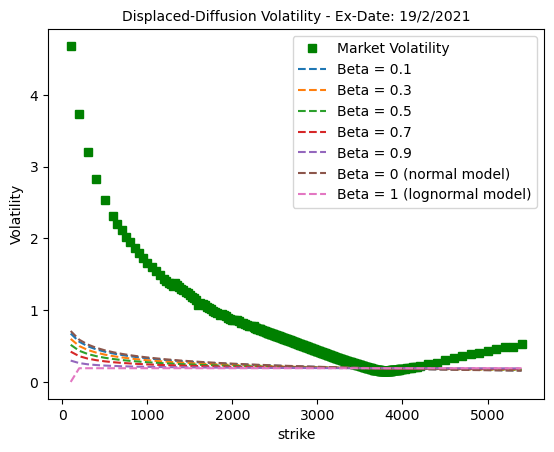

In [14]:
# Displaced Diffusion Volatility (exdate3)
spx_call3 = spx3[(spx3.cp_flag == "C")].reset_index(drop=True)
spx_put3 = spx3[(spx3.cp_flag == "P")].reset_index(drop=True)
strike3 = spx_put3["strike_price"].values

summary3 = []
for i in range(len(spx_put3.index)):
    K = strike3[i]
    if K <= S:
        impliedvol_market = impliedPutVolatility(S, K, r3, spx_put3['mid_price'][i], T3)

        price_lognormal = BlackScholesPut(S, K, r3, sigma3, T3)
        impliedvol_lognormal = impliedPutVolatility(S, K, r3, price_lognormal, T3)

        price_normal = BachelierPut(S, K, r3, sigma3, T3)
        impliedvol_normal = impliedPutVolatility(S, K, r3, price_normal, T3)

        price_dd1 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r3, price_dd1, T3)

        price_dd2 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r3, price_dd2, T3)

        price_dd3 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r3, price_dd3, T3)

        price_dd4 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r3, price_dd4, T3)

        price_dd5 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta5)
        impliedvol_dd5 = impliedPutVolatility(S, K, r3, price_dd5, T3)

    elif K > S:
        impliedvol_market = impliedCallVolatility(S, K, r3, spx_call3['mid_price'][i], T3)

        price_lognormal = BlackScholesCall(S, K, r3, sigma3, T3)
        impliedvol_lognormal = impliedCallVolatility(S, K, r3, price_lognormal, T3)

        price_normal = BachelierCall(S, K, r3, sigma3, T3)
        impliedvol_normal = impliedCallVolatility(S, K, r3, price_normal, T3)

        price_dd1 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r3, price_dd1, T3)

        price_dd2 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r3, price_dd2, T3)

        price_dd3 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r3, price_dd3, T3)

        price_dd4 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r3, price_dd4, T3)

        price_dd5 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta5)
        impliedvol_dd5 = impliedCallVolatility(S, K, r3, price_dd5, T3)

    summary3.append([K,
                     impliedvol_market,
                     impliedvol_lognormal,
                     impliedvol_normal,
                     impliedvol_dd1,
                     impliedvol_dd2,
                     impliedvol_dd3,
                     impliedvol_dd4,
                     impliedvol_dd5])

dd_3 = pd.DataFrame(summary3, columns=['strike',
                                       'impliedvol_market',
                                       'impliedvol_lognormal',
                                       'impliedvol_normal',
                                       'impliedvol_dd1',
                                       'impliedvol_dd2',
                                       'impliedvol_dd3',
                                       'impliedvol_dd4',
                                       'impliedvol_dd5'])
plt.plot(dd_1['strike'], dd_1['impliedvol_market'], 'gs', label = 'Market Volatility')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_dd5'], label = f'Beta = {beta5}', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_dd4'], label = f'Beta = {beta4}', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_dd3'], label = f'Beta = {beta3}', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_dd2'], label = f'Beta = {beta2}', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_dd1'], label = f'Beta = {beta1}', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_normal'], label = 'Beta = 0 (normal model)', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_lognormal'], label = 'Beta = 1 (lognormal model)', linestyle = '--')

plt.legend()
plt.title('Displaced-Diffusion Volatility - Ex-Date: 19/2/2021',
          fontsize = 10)
plt.ylabel('Volatility')
plt.show()

### Calibrating SPX Displaced-Diffusion

C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:10: RuntimeWarning: invalid value encountered in scalar divide
  c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return np.exp(-r*T)*(((1-beta)/beta*F + K)*norm.cdf(-c2) - F/beta*norm.cdf(-c1))
C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:4: RuntimeWarning: invalid value encountered in scalar divide
  c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  return np.exp(-r*T)*(F/beta*norm.cdf(c1) - ((1-beta)/beta*F + K)*norm.cdf(c2))


ExDate1: 18/12/2020
Calibrated Sigma: 0.2
Calibrated Beta: 0.5


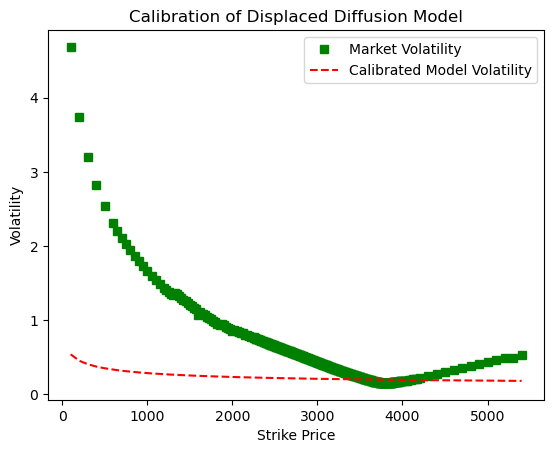

In [16]:
initial_guess = [0.2, 0.5]  # Initial guess for sigma and beta
bounds = [(1e-6, 1), (0.0, 1.0)]  # Bounds for sigma and beta

strikes = spx1['strike_price'].values
market_vols = dd_1['impliedvol_market'].values  # Extract market implied volatilities

result = minimize(
    calibration_objective,
    initial_guess,
    args=(strikes, market_vols, S, r1, T1),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract calibrated parameters
calibrated_sigma, calibrated_beta = result.x

# Align strikes with market vols (handle mismatches)
if len(market_vols) < len(strikes):
    strikes = strikes[:len(market_vols)]  # Slice strikes to match market_vols

# Calculate calibrated model volatilities
calibrated_vols = []
for K in strikes:
    if K <= S:
        model_price = DisplacedDiffusionPut(S, K, r1, calibrated_sigma, T1, calibrated_beta)
        implied_vol = impliedPutVolatility(S, K, r1, model_price, T1)
    else:
        model_price = DisplacedDiffusionCall(S, K, r1, calibrated_sigma, T1, calibrated_beta)
        implied_vol = impliedCallVolatility(S, K, r1, model_price, T1)
    calibrated_vols.append(implied_vol)

# Verify alignment
print("ExDate1: 18/12/2020")
print("Calibrated Sigma:", calibrated_sigma)
print("Calibrated Beta:", calibrated_beta)

# Plot the corrected data
plt.plot(strikes, market_vols, 'gs', label='Market Volatility')
plt.plot(strikes, calibrated_vols[:len(strikes)], 'r--', label='Calibrated Model Volatility')
plt.legend()
plt.title('Calibration of Displaced Diffusion Model')
plt.xlabel('Strike Price')
plt.ylabel('Volatility')
plt.show()

C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:10: RuntimeWarning: invalid value encountered in scalar divide
  c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return np.exp(-r*T)*(((1-beta)/beta*F + K)*norm.cdf(-c2) - F/beta*norm.cdf(-c1))
C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:4: RuntimeWarning: invalid value encountered in scalar divide
  c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  return np.exp(-r*T)*(F/beta*norm.cdf(c1) - ((1-beta)/beta*F + K)*norm.cdf(c2))


ExDate2: 15/01/2021
Calibrated Sigma: 0.2
Calibrated Beta: 0.5


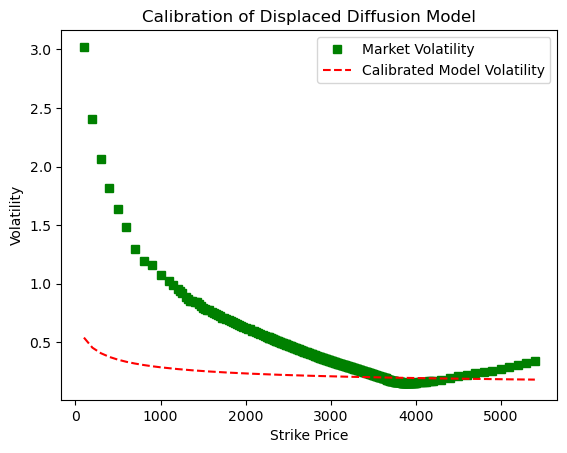

In [17]:
initial_guess = [0.2, 0.5]  # Initial guess for sigma and beta
bounds = [(1e-6, 1), (0.0, 1.0)]  # Bounds for sigma and beta

strikes = spx2['strike_price'].values
market_vols = dd_2['impliedvol_market'].values  # Extract market implied volatilities

result = minimize(
    calibration_objective,
    initial_guess,
    args=(strikes, market_vols, S, r2, T2),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract calibrated parameters
calibrated_sigma, calibrated_beta = result.x

# Align strikes with market vols (handle mismatches)
if len(market_vols) < len(strikes):
    strikes = strikes[:len(market_vols)]  # Slice strikes to match market_vols

# Calculate calibrated model volatilities
calibrated_vols = []
for K in strikes:
    if K <= S:
        model_price = DisplacedDiffusionPut(S, K, r1, calibrated_sigma, T1, calibrated_beta)
        implied_vol = impliedPutVolatility(S, K, r1, model_price, T1)
    else:
        model_price = DisplacedDiffusionCall(S, K, r1, calibrated_sigma, T1, calibrated_beta)
        implied_vol = impliedCallVolatility(S, K, r1, model_price, T1)
    calibrated_vols.append(implied_vol)

# Verify alignment
print("ExDate2: 15/01/2021")
print("Calibrated Sigma:", calibrated_sigma)
print("Calibrated Beta:", calibrated_beta)

# Plot the corrected data
plt.plot(strikes, market_vols, 'gs', label='Market Volatility')
plt.plot(strikes, calibrated_vols[:len(strikes)], 'r--', label='Calibrated Model Volatility')
plt.legend()
plt.title('Calibration of Displaced Diffusion Model')
plt.xlabel('Strike Price')
plt.ylabel('Volatility')
plt.show()

C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:10: RuntimeWarning: invalid value encountered in scalar divide
  c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return np.exp(-r*T)*(((1-beta)/beta*F + K)*norm.cdf(-c2) - F/beta*norm.cdf(-c1))
C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:4: RuntimeWarning: invalid value encountered in scalar divide
  c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  return np.exp(-r*T)*(F/beta*norm.cdf(c1) - ((1-beta)/beta*F + K)*norm.cdf(c2))


ExDate3: 19/02/2021
Calibrated Sigma: 0.2
Calibrated Beta: 0.5


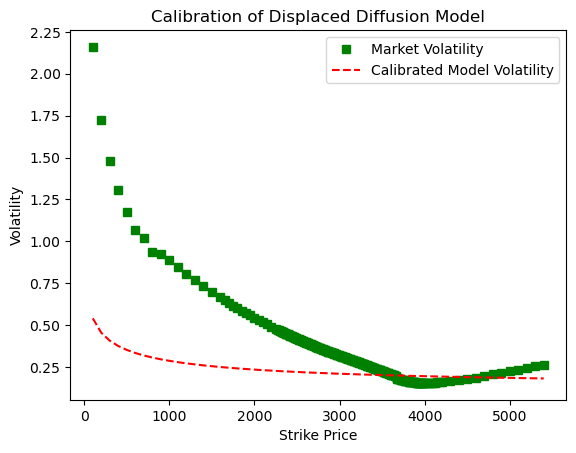

In [18]:
initial_guess = [0.2, 0.5]  # Initial guess for sigma and beta
bounds = [(1e-6, 1), (0.0, 1.0)]  # Bounds for sigma and beta

strikes = spx3['strike_price'].values
market_vols = dd_3['impliedvol_market'].values  # Extract market implied volatilities

result = minimize(
    calibration_objective,
    initial_guess,
    args=(strikes, market_vols, S, r1, T1),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract calibrated parameters
calibrated_sigma, calibrated_beta = result.x

# Align strikes with market vols (handle mismatches)
if len(market_vols) < len(strikes):
    strikes = strikes[:len(market_vols)]  # Slice strikes to match market_vols

# Calculate calibrated model volatilities
calibrated_vols = []
for K in strikes:
    if K <= S:
        model_price = DisplacedDiffusionPut(S, K, r1, calibrated_sigma, T1, calibrated_beta)
        implied_vol = impliedPutVolatility(S, K, r1, model_price, T1)
    else:
        model_price = DisplacedDiffusionCall(S, K, r1, calibrated_sigma, T1, calibrated_beta)
        implied_vol = impliedCallVolatility(S, K, r1, model_price, T1)
    calibrated_vols.append(implied_vol)

# Verify alignment
print("ExDate3: 19/02/2021")
print("Calibrated Sigma:", calibrated_sigma)
print("Calibrated Beta:", calibrated_beta)

# Plot the corrected data
plt.plot(strikes, market_vols, 'gs', label='Market Volatility')
plt.plot(strikes, calibrated_vols[:len(strikes)], 'r--', label='Calibrated Model Volatility')
plt.legend()
plt.title('Calibration of Displaced Diffusion Model')
plt.xlabel('Strike Price')
plt.ylabel('Volatility')
plt.show()

# 2. SPY Options

In [20]:
# Discount Rate
rate_df = pd.read_csv('zero_rates_20201201.csv')

# SPX General Data
spy_df = pd.read_csv('SPY_options.csv')
spy_df['strike_price'] = spy_df['strike_price']/1000
spy_df['mid_price'] = (spy_df['best_bid'] + spy_df['best_offer'])/2

# SPX Maturity Data
spy1 = spy_df[(spy_df.exdate == 20201218)]
spy2 = spy_df[(spy_df.exdate == 20210115)]
spy3 = spy_df[(spy_df.exdate == 20210219)]

# Time To Maturity
today = dt.date(2020, 12, 1)
exdate1 = dt.date(2020, 12, 18)
exdate2 = dt.date(2021, 1, 15)
exdate3 = dt.date(2021, 2, 19)
T1 = (exdate1-today).days/365.0
T2 = (exdate2-today).days/365.0
T3 = (exdate3-today).days/365.0

# Discount Rate Interpolation
x = rate_df['days']
y = rate_df['rate']
f = interpolate.interp1d(x,y)
r1 = f(T1*365)/100
r2 = f(T2*365)/100
r3 = f(T3*365)/100

# Underlying Value & ATM Strike Price
S = 366.02
K = 366

# Beta Parameter (Displaced-Diffusion Model)
#beta1 = 1.0
beta1 = 0.9
beta2 = 0.7
beta3 = 0.5
beta4 = 0.3
beta5 = 0.1

# Steps Parameter (American Options)
steps = 20

### Date1: 18/12/2020

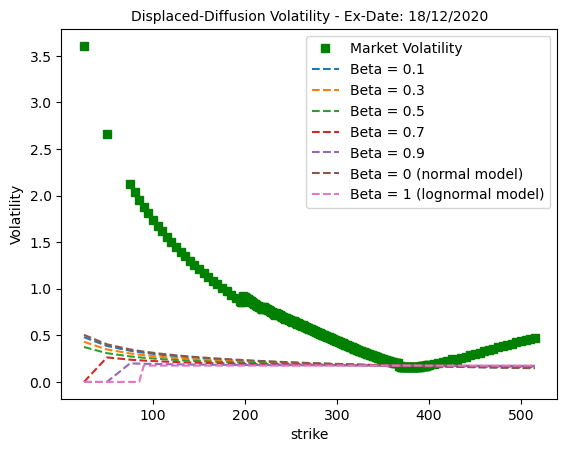

In [22]:
# Displaced Diffusion Volatility (exdate1)

spy_call1 = spy1[(spy1.cp_flag == "C")].reset_index(drop=True)
spy_put1 = spy1[(spy1.cp_flag == "P")].reset_index(drop=True)
strike1 = spy_put1["strike_price"].values

summary1 = []
for i in range(len(spy_put1.index)):
    K = strike1[i]
    if K <= S:
        impliedvol_market = impliedPutVolatility(S, K, r1, spy_put1['mid_price'][i], T1)

        price_lognormal = BlackScholesPut(S, K, r1, sigma1, T1)
        impliedvol_lognormal = impliedPutVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierPut(S, K, r1, sigma1, T1)
        impliedvol_normal = impliedPutVolatility(S, K, r1, price_normal, T1)

        price_dd1 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r1, price_dd1, T1)

        price_dd2 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r1, price_dd2, T1)

        price_dd3 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r1, price_dd3, T1)

        price_dd4 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r1, price_dd4, T1)

        price_dd5 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta5)
        impliedvol_dd5 = impliedPutVolatility(S, K, r1, price_dd5, T1)

    elif K > S:
        impliedvol_market = impliedCallVolatility(S, K, r1, spy_call1['mid_price'][i], T1)

        price_lognormal = BlackScholesCall(S, K, r1, sigma1, T1)
        impliedvol_lognormal = impliedCallVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierCall(S, K, r1, sigma1, T1)
        impliedvol_normal = impliedCallVolatility(S, K, r1, price_normal, T1)

        price_dd1 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r1, price_dd1, T1)

        price_dd2 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r1, price_dd2, T1)

        price_dd3 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r1, price_dd3, T1)

        price_dd4 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r1, price_dd4, T1)

        price_dd5 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta5)
        impliedvol_dd5 = impliedCallVolatility(S, K, r1, price_dd5, T1)

    summary1.append([K,
                    impliedvol_market,
                    impliedvol_lognormal,
                    impliedvol_normal,
                    impliedvol_dd1,
                    impliedvol_dd2,
                    impliedvol_dd3,
                    impliedvol_dd4,
                    impliedvol_dd5
                    ])

dd_1 = pd.DataFrame(summary1, columns=['strike',
                                        'impliedvol_market',
                                        'impliedvol_lognormal',
                                        'impliedvol_normal',
                                        'impliedvol_dd1',
                                        'impliedvol_dd2',
                                        'impliedvol_dd3',
                                        'impliedvol_dd4',
                                        'impliedvol_dd5'
                                        ])
plt.plot(dd_1['strike'], dd_1['impliedvol_market'], 'gs', label = 'Market Volatility')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd5'], label = f'Beta = {beta5}', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd4'], label = f'Beta = {beta4}', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd3'], label = f'Beta = {beta3}', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd2'], label = f'Beta = {beta2}', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd1'], label = f'Beta = {beta1}', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_normal'], label = 'Beta = 0 (normal model)', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_lognormal'], label = 'Beta = 1 (lognormal model)', linestyle = '--')

plt.legend()
plt.title('Displaced-Diffusion Volatility - Ex-Date: 18/12/2020',
          fontsize = 10)
plt.ylabel('Volatility')
plt.show()


### Date2: 15/01/2021

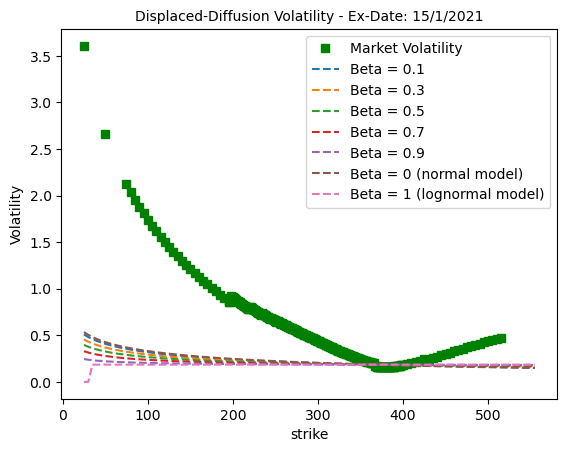

In [24]:
# Displaced Diffusion Volatility (exdate2)
spy_call2 = spy2[(spy2.cp_flag == "C")].reset_index(drop=True)
spy_put2 = spy2[(spy2.cp_flag == "P")].reset_index(drop=True)
strike2 = spy_put2["strike_price"].values

summary2 = []
for i in range(len(spy_put2.index)):
    K = strike2[i]
    if K <= S:
        impliedvol_market = impliedPutVolatility(S, K, r2, spy_put2['mid_price'][i], T2)

        price_lognormal = BlackScholesPut(S, K, r2, sigma2, T2)
        impliedvol_lognormal = impliedPutVolatility(S, K, r2, price_lognormal, T2)

        price_normal = BachelierPut(S, K, r2, sigma2, T2)
        impliedvol_normal = impliedPutVolatility(S, K, r2, price_normal, T2)

        price_dd1 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r2, price_dd1, T2)

        price_dd2 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r2, price_dd2, T2)

        price_dd3 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r2, price_dd3, T2)

        price_dd4 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r2, price_dd4, T2)

        price_dd5 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta5)
        impliedvol_dd5 = impliedPutVolatility(S, K, r2, price_dd5, T2)

    elif K > S:
        impliedvol_market = impliedCallVolatility(S, K, r2, spy_call2['mid_price'][i], T2)

        price_lognormal = BlackScholesCall(S, K, r2, sigma2, T2)
        impliedvol_lognormal = impliedCallVolatility(S, K, r2, price_lognormal, T2)

        price_normal = BachelierCall(S, K, r2, sigma2, T2)
        impliedvol_normal = impliedCallVolatility(S, K, r2, price_normal, T2)

        price_dd1 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r2, price_dd1, T2)

        price_dd2 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r2, price_dd2, T2)

        price_dd3 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r2, price_dd3, T2)

        price_dd4 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r2, price_dd4, T2)

        price_dd5 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta5)
        impliedvol_dd5 = impliedCallVolatility(S, K, r2, price_dd5, T2)

    summary2.append([K,
                     impliedvol_market,
                     impliedvol_lognormal,
                     impliedvol_normal,
                     impliedvol_dd1,
                     impliedvol_dd2,
                     impliedvol_dd3,
                     impliedvol_dd4,
                     impliedvol_dd5])

dd_2 = pd.DataFrame(summary2, columns=['strike',
                                       'impliedvol_market',
                                       'impliedvol_lognormal',
                                       'impliedvol_normal',
                                       'impliedvol_dd1',
                                       'impliedvol_dd2',
                                       'impliedvol_dd3',
                                       'impliedvol_dd4',
                                       'impliedvol_dd5'])
plt.plot(dd_1['strike'], dd_1['impliedvol_market'], 'gs', label = 'Market Volatility')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_dd5'], label = f'Beta = {beta5}', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_dd4'], label = f'Beta = {beta4}', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_dd3'], label = f'Beta = {beta3}', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_dd2'], label = f'Beta = {beta2}', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_dd1'], label = f'Beta = {beta1}', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_normal'], label = 'Beta = 0 (normal model)', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_lognormal'], label = 'Beta = 1 (lognormal model)', linestyle = '--')

plt.legend()
plt.title('Displaced-Diffusion Volatility - Ex-Date: 15/1/2021',
          fontsize = 10)
plt.ylabel('Volatility')
plt.show()



### Date3: 19/02/2021

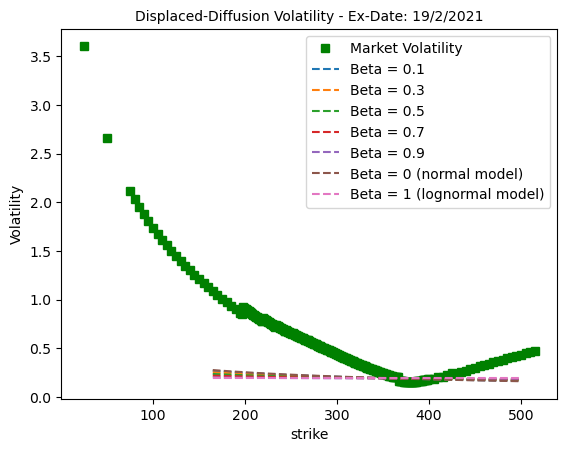

In [26]:
# Displaced Diffusion Volatility (exdate3)
spy_call3 = spy3[(spy3.cp_flag == "C")].reset_index(drop=True)
spy_put3 = spy3[(spy3.cp_flag == "P")].reset_index(drop=True)
strike3 = spy_put3["strike_price"].values

summary3 = []
for i in range(len(spy_put3.index)):
    K = strike3[i]
    if K <= S:
        impliedvol_market = impliedPutVolatility(S, K, r3, spy_put3['mid_price'][i], T3)

        price_lognormal = BlackScholesPut(S, K, r3, sigma3, T3)
        impliedvol_lognormal = impliedPutVolatility(S, K, r3, price_lognormal, T3)

        price_normal = BachelierPut(S, K, r3, sigma3, T3)
        impliedvol_normal = impliedPutVolatility(S, K, r3, price_normal, T3)

        price_dd1 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r3, price_dd1, T3)

        price_dd2 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r3, price_dd2, T3)

        price_dd3 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r3, price_dd3, T3)

        price_dd4 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r3, price_dd4, T3)

        price_dd5 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta5)
        impliedvol_dd5 = impliedPutVolatility(S, K, r3, price_dd5, T3)

    elif K > S:
        impliedvol_market = impliedCallVolatility(S, K, r3, spy_call3['mid_price'][i], T3)

        price_lognormal = BlackScholesCall(S, K, r3, sigma3, T3)
        impliedvol_lognormal = impliedCallVolatility(S, K, r3, price_lognormal, T3)

        price_normal = BachelierCall(S, K, r3, sigma3, T3)
        impliedvol_normal = impliedCallVolatility(S, K, r3, price_normal, T3)

        price_dd1 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r3, price_dd1, T3)

        price_dd2 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r3, price_dd2, T3)

        price_dd3 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r3, price_dd3, T3)

        price_dd4 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r3, price_dd4, T3)

        price_dd5 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta5)
        impliedvol_dd5 = impliedCallVolatility(S, K, r3, price_dd5, T3)

    summary3.append([K,
                     impliedvol_market,
                     impliedvol_lognormal,
                     impliedvol_normal,
                     impliedvol_dd1,
                     impliedvol_dd2,
                     impliedvol_dd3,
                     impliedvol_dd4,
                     impliedvol_dd5])

dd_3 = pd.DataFrame(summary3, columns=['strike',
                                       'impliedvol_market',
                                       'impliedvol_lognormal',
                                       'impliedvol_normal',
                                       'impliedvol_dd1',
                                       'impliedvol_dd2',
                                       'impliedvol_dd3',
                                       'impliedvol_dd4',
                                       'impliedvol_dd5'])
plt.plot(dd_1['strike'], dd_1['impliedvol_market'], 'gs', label = 'Market Volatility')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_dd5'], label = f'Beta = {beta5}', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_dd4'], label = f'Beta = {beta4}', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_dd3'], label = f'Beta = {beta3}', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_dd2'], label = f'Beta = {beta2}', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_dd1'], label = f'Beta = {beta1}', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_normal'], label = 'Beta = 0 (normal model)', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_lognormal'], label = 'Beta = 1 (lognormal model)', linestyle = '--')

plt.legend()
plt.title('Displaced-Diffusion Volatility - Ex-Date: 19/2/2021',
          fontsize = 10)
plt.ylabel('Volatility')
plt.show()


### Calibrating SPY Displaced-Diffusion

C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:10: RuntimeWarning: invalid value encountered in scalar divide
  c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return np.exp(-r*T)*(((1-beta)/beta*F + K)*norm.cdf(-c2) - F/beta*norm.cdf(-c1))
C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:4: RuntimeWarning: invalid value encountered in scalar divide
  c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  return np.exp(-r*T)*(F/beta*norm.cdf(c1) - ((1-beta)/beta*F + K)*norm.cdf(c2))


ExDate1: 18/12/2020
Calibrated Sigma: 0.2
Calibrated Beta: 0.5


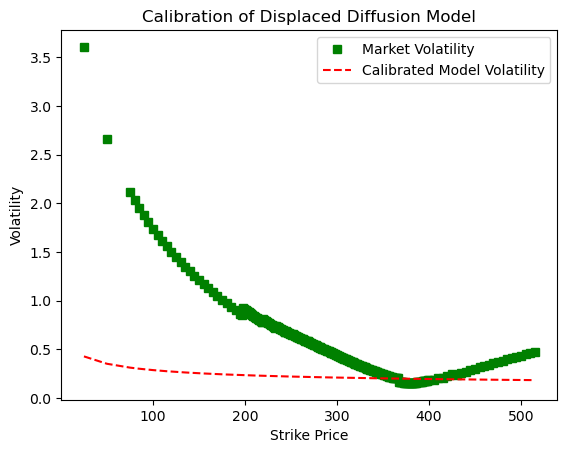

In [28]:
initial_guess = [0.2, 0.5]  # Initial guess for sigma and beta
bounds = [(1e-6, 1), (0.0, 1.0)]  # Bounds for sigma and beta

strikes = spy1['strike_price'].values
market_vols = dd_1['impliedvol_market'].values  # Extract market implied volatilities

result = minimize(
    calibration_objective,
    initial_guess,
    args=(strikes, market_vols, S, r1, T1),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract calibrated parameters
calibrated_sigma, calibrated_beta = result.x

# Align strikes with market vols (handle mismatches)
if len(market_vols) < len(strikes):
    strikes = strikes[:len(market_vols)]  # Slice strikes to match market_vols

# Calculate calibrated model volatilities
calibrated_vols = []
for K in strikes:
    if K <= S:
        model_price = DisplacedDiffusionPut(S, K, r1, calibrated_sigma, T1, calibrated_beta)
        implied_vol = impliedPutVolatility(S, K, r1, model_price, T1)
    else:
        model_price = DisplacedDiffusionCall(S, K, r1, calibrated_sigma, T1, calibrated_beta)
        implied_vol = impliedCallVolatility(S, K, r1, model_price, T1)
    calibrated_vols.append(implied_vol)

# Verify alignment
print("ExDate1: 18/12/2020")
print("Calibrated Sigma:", calibrated_sigma)
print("Calibrated Beta:", calibrated_beta)

# Plot the corrected data
plt.plot(strikes, market_vols, 'gs', label='Market Volatility')
plt.plot(strikes, calibrated_vols[:len(strikes)], 'r--', label='Calibrated Model Volatility')
plt.legend()
plt.title('Calibration of Displaced Diffusion Model')
plt.xlabel('Strike Price')
plt.ylabel('Volatility')
plt.show()

C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:10: RuntimeWarning: invalid value encountered in scalar divide
  c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return np.exp(-r*T)*(((1-beta)/beta*F + K)*norm.cdf(-c2) - F/beta*norm.cdf(-c1))
C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:4: RuntimeWarning: invalid value encountered in scalar divide
  c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  return np.exp(-r*T)*(F/beta*norm.cdf(c1) - ((1-beta)/beta*F + K)*norm.cdf(c2))


ExDate2: 15/01/2021
Calibrated Sigma: 0.2
Calibrated Beta: 0.5


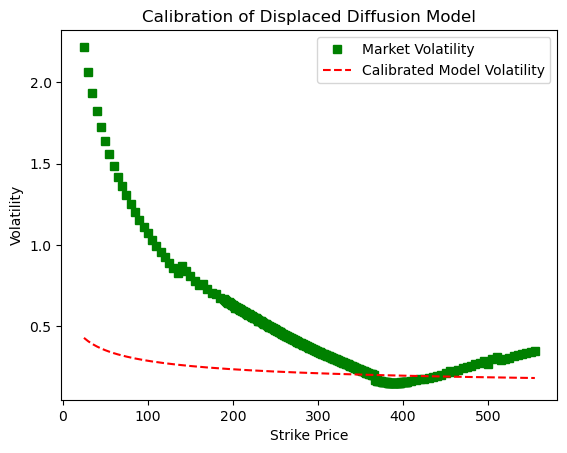

In [29]:
initial_guess = [0.2, 0.5]  # Initial guess for sigma and beta
bounds = [(1e-6, 1), (0.0, 1.0)]  # Bounds for sigma and beta

strikes = spy2['strike_price'].values
market_vols = dd_2['impliedvol_market'].values  # Extract market implied volatilities

result = minimize(
    calibration_objective,
    initial_guess,
    args=(strikes, market_vols, S, r1, T1),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract calibrated parameters
calibrated_sigma, calibrated_beta = result.x

# Align strikes with market vols (handle mismatches)
if len(market_vols) < len(strikes):
    strikes = strikes[:len(market_vols)]  # Slice strikes to match market_vols

# Calculate calibrated model volatilities
calibrated_vols = []
for K in strikes:
    if K <= S:
        model_price = DisplacedDiffusionPut(S, K, r1, calibrated_sigma, T1, calibrated_beta)
        implied_vol = impliedPutVolatility(S, K, r1, model_price, T1)
    else:
        model_price = DisplacedDiffusionCall(S, K, r1, calibrated_sigma, T1, calibrated_beta)
        implied_vol = impliedCallVolatility(S, K, r1, model_price, T1)
    calibrated_vols.append(implied_vol)
# Verify alignment
print("ExDate2: 15/01/2021")
print("Calibrated Sigma:", calibrated_sigma)
print("Calibrated Beta:", calibrated_beta)

# Plot the corrected data
plt.plot(strikes, market_vols, 'gs', label='Market Volatility')
plt.plot(strikes, calibrated_vols[:len(strikes)], 'r--', label='Calibrated Model Volatility')
plt.legend()
plt.title('Calibration of Displaced Diffusion Model')
plt.xlabel('Strike Price')
plt.ylabel('Volatility')
plt.show()

C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:10: RuntimeWarning: invalid value encountered in scalar divide
  c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return np.exp(-r*T)*(((1-beta)/beta*F + K)*norm.cdf(-c2) - F/beta*norm.cdf(-c1))
C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:4: RuntimeWarning: invalid value encountered in scalar divide
  c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
C:\Users\miche\AppData\Local\Temp\ipykernel_13188\1095653124.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  return np.exp(-r*T)*(F/beta*norm.cdf(c1) - ((1-beta)/beta*F + K)*norm.cdf(c2))


ExDate3: 19/02/2021
Calibrated Sigma: 0.2
Calibrated Beta: 0.5


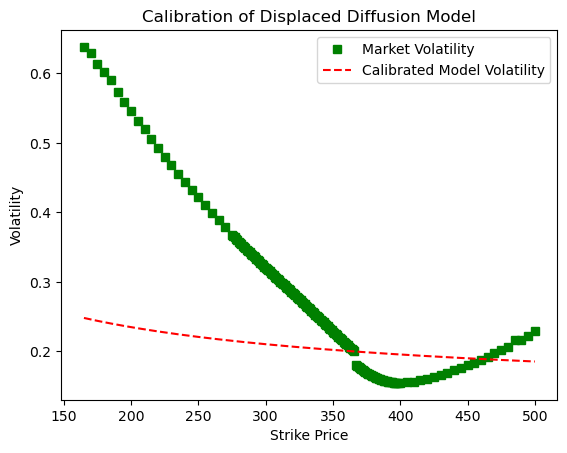

In [30]:
initial_guess = [0.2, 0.5]  # Initial guess for sigma and beta
bounds = [(1e-6, 1), (0.0, 1.0)]  # Bounds for sigma and beta

strikes = spy3['strike_price'].values
market_vols = dd_3['impliedvol_market'].values  # Extract market implied volatilities

result = minimize(
    calibration_objective,
    initial_guess,
    args=(strikes, market_vols, S, r1, T1),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract calibrated parameters
calibrated_sigma, calibrated_beta = result.x

# Align strikes with market vols (handle mismatches)
if len(market_vols) < len(strikes):
    strikes = strikes[:len(market_vols)]  # Slice strikes to match market_vols

# Calculate calibrated model volatilities
calibrated_vols = []
for K in strikes:
    if K <= S:
        model_price = DisplacedDiffusionPut(S, K, r1, calibrated_sigma, T1, calibrated_beta)
        implied_vol = impliedPutVolatility(S, K, r1, model_price, T1)
    else:
        model_price = DisplacedDiffusionCall(S, K, r1, calibrated_sigma, T1, calibrated_beta)
        implied_vol = impliedCallVolatility(S, K, r1, model_price, T1)
    calibrated_vols.append(implied_vol)

# Verify alignment
print("ExDate3: 19/02/2021")
print("Calibrated Sigma:", calibrated_sigma)
print("Calibrated Beta:", calibrated_beta)

# Plot the corrected data
plt.plot(strikes, market_vols, 'gs', label='Market Volatility')
plt.plot(strikes, calibrated_vols[:len(strikes)], 'r--', label='Calibrated Model Volatility')
plt.legend()
plt.title('Calibration of Displaced Diffusion Model')
plt.xlabel('Strike Price')
plt.ylabel('Volatility')
plt.show()

# SABR Model

## Import Dependencies

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import datetime as dt
import array
from scipy.stats import norm
from scipy.optimize import brentq,fsolve
from scipy import interpolate
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore")

## Importing relevant functions

In [35]:
# Black-Scholes Model
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# def DisplacedDiffusionCall(F, K, r, sigma, T, beta):
#     c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
#     c2 = c1 - beta*sigma*np.sqrt(T)
#     disc = np.exp(-r*T)
#     return disc*(F/beta*norm.cdf(c1) - ((1-beta)/beta*F + K)*norm.cdf(c2))


# def DisplacedDiffusionPut(F, K, r, sigma, T, beta):
#     c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
#     c2 = c1 - beta*sigma*np.sqrt(T)
#     disc = np.exp(-r*T)
#     return disc*(((1-beta)/beta*F + K)*norm.cdf(-c2) - F/beta*norm.cdf(-c1))

def DisplacedDiffusionCall(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    disc = np.exp(-r*T)
    return disc*(F/beta*norm.cdf(c1) - ((1-beta)/beta*F + K)*norm.cdf(c2))

def DisplacedDiffusionPut(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    disc = np.exp(-r*T)
    return disc*(((1-beta)/beta*F + K)*norm.cdf(-c2) - F/beta*norm.cdf(-c1))

In [36]:
def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

# Step 1: Prepare and Cleanup Datasets

In [38]:
#### Step 1 Data Import for SPY & Data Cleanup

####################################################################
####################################################################
####################################################################
####################################################################


####################################################################
### 1.1A Working on SPX

print("1.1A Below is SPX related variables")

## SPX
S_spx = 3662.45
display("S_spx: {S_spx}")

## SPX Data
spx_df = pd.read_csv('SPX_options.csv')
spx_df['strike'] = spx_df['strike_price']/1000  # All strike prices need to / 1000 to get actual strike
spx_df['mid'] = (spx_df['best_bid'] + spx_df['best_offer'])/2  # get the midprice as average of best bid & best offer
spx_df['payoff'] = spx_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')


## Check Distribution of Data
display(spx_df['exdate'].unique()) ## Check unique number of expiry dates
display(spx_df['cp_flag'].value_counts()) # Check number of calls and puts
display(spx_df['exercise_style'].unique()) # Check number of calls and puts

## Obtain All 3 Time to Maturity for each of the 3 Expiry Date
today = dt.date(2020, 12, 1)
expiries = [pd.Timestamp(str(x)).date() for x in spx_df['exdate'].unique()]  # Conversion from string to pd.TimeStamp format
T_SPX = [(exdate-today).days/365.0 for exdate in expiries] # T = Time to Expiry - Today (i.e. dt.date(2020, 12, 1))
display(dict(zip(expiries, T_SPX)))



####################################################################
### 1.1B Working on SPY

## SPY
S_spy = 366.02
display("S_spy: {S_spy}")

print("1.1B Below is SPY related variables")
## SPY Data
spy_df = pd.read_csv('SPY_options.csv')
spy_df['strike'] = spy_df['strike_price']/1000  # All strike prices need to / 1000 to get actual strike
spy_df['mid'] = (spy_df['best_bid'] + spy_df['best_offer'])/2  # get the midprice as average of best bid & best offer
spy_df['payoff'] = spy_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')


## Check Distribution of Data
display(spy_df['exdate'].unique()) ## Check unique number of expiry dates
display(spy_df['cp_flag'].value_counts()) # Check number of calls and puts
display(spy_df['exercise_style'].unique())

## Obtain All 3 Time to Maturity for each of the 3 Expiry Date
today = dt.date(2020, 12, 1)
expiries = [pd.Timestamp(str(x)).date() for x in spy_df['exdate'].unique()]  # Conversion from string to pd.TimeStamp format
T_SPY = [(exdate-today).days/365.0 for exdate in expiries] # T = Time to Expiry - Today (i.e. dt.date(2020, 12, 1))
display(dict(zip(expiries, T_SPY)))

###################################################################
### 1.2 Working on Discount Rates

print("1.2 Below is Discount Rates")
## Discount Rate
rates_df = pd.read_csv('zero_rates_20201201.csv')
display(rates_df.head())

## Get Days to Expiry for each Expiry Date
days_to_expiry = [(expiry - today).days for expiry in expiries]
display(dict(zip(expiries, days_to_expiry)))


## Interpolate Discount Rates (discount rates to be used for each Expiry Date)
zero_rate_curve = interp1d(rates_df['days'],rates_df['rate'])
discount_rates = (zero_rate_curve(days_to_expiry) / 100) # to be used as r in exp(-rT)
print("The respective r and T we use inside exp(-rT) for SPX")
display(tuple(zip(expiries, discount_rates, T_SPX)))
print("The respective r and T we use inside exp(-rT) for SPY")
display(tuple(zip(expiries, discount_rates, T_SPY)))
print("Notice they have the same Expiry Dates and hence same r and T")



###################################################################
### 1.3 Working on Underlying and Forward Prices

## Underlying Value & Forward Value for SPY
print("1.3 Below is Underlying and Forward Prices, for SPX and SPY")
F_spx= S_spx*np.exp(-discount_rates*T_SPX)
F_spy= S_spy*np.exp(-discount_rates*T_SPY)
print(f"Underlying Prices for SPX {S_spx}, for SPY {S_spy}")
print(f"Forward Prices for SPX {F_spx}, for SPY {F_spy}")

###################################################################
### 1.4 Combine Data together


## Create aa mapping for discount rates and the time to expiry
formatted_dates = [date.strftime("%Y%m%d") for date in expiries]
formatted_dates = [int(date) for date in formatted_dates]
discount_rates_df_final = pd.DataFrame({"exdate":formatted_dates,
                                        "r":discount_rates,
                                        "T": T_SPX})

# Create rates column in SPY & SPX dfs
spx_df = pd.merge(spx_df, discount_rates_df_final,
                  how = 'left', on = 'exdate')
spy_df = pd.merge(spy_df, discount_rates_df_final,
                  how = 'left', on = 'exdate')

## Create vols columns in SPY & SPX dfs
spx_df['vols'] = spx_df.apply(lambda x: impliedVolatility(S_spx,
                                                  x['strike'],
                                                  x['r'],
                                                  x['mid'],#replace with a c
                                                  x['T'],
                                                  x['payoff']),
                      axis=1)
spy_df['vols'] = spy_df.apply(lambda x: impliedVolatility(S_spy,
                                                  x['strike'],
                                                  x['r'],
                                                  x['mid'],
                                                  x['T'],
                                                  x['payoff']),
                      axis=1)

### drop NAs (dk why the implied vols have quite a number of NAs)
spx_df.dropna(inplace=True)
spy_df.dropna(inplace=True)



1.1A Below is SPX related variables


'S_spx: {S_spx}'

array([20201218, 20210115, 20210219], dtype=int64)

cp_flag
C    1036
P    1036
Name: count, dtype: int64

array(['E'], dtype=object)

{datetime.date(2020, 12, 18): 0.04657534246575343,
 datetime.date(2021, 1, 15): 0.1232876712328767,
 datetime.date(2021, 2, 19): 0.2191780821917808}

'S_spy: {S_spy}'

1.1B Below is SPY related variables


array([20201218, 20210115, 20210219], dtype=int64)

cp_flag
C    700
P    700
Name: count, dtype: int64

array(['A'], dtype=object)

{datetime.date(2020, 12, 18): 0.04657534246575343,
 datetime.date(2021, 1, 15): 0.1232876712328767,
 datetime.date(2021, 2, 19): 0.2191780821917808}

1.2 Below is Discount Rates


,date,days,rate
0,20201201,7,0.102280
1,20201201,13,0.114128
2,20201201,49,0.216480
3,20201201,77,0.220707
4,20201201,104,0.219996


{datetime.date(2020, 12, 18): 17,
 datetime.date(2021, 1, 15): 45,
 datetime.date(2021, 2, 19): 80}

The respective r and T we use inside exp(-rT) for SPX


((datetime.date(2020, 12, 18), 0.0012550044444444445, 0.04657534246575343),
 (datetime.date(2021, 1, 15), 0.0020510755555555554, 0.1232876712328767),
 (datetime.date(2021, 2, 19), 0.0022062799999999997, 0.2191780821917808))

The respective r and T we use inside exp(-rT) for SPY


((datetime.date(2020, 12, 18), 0.0012550044444444445, 0.04657534246575343),
 (datetime.date(2021, 1, 15), 0.0020510755555555554, 0.1232876712328767),
 (datetime.date(2021, 2, 19), 0.0022062799999999997, 0.2191780821917808))

Notice they have the same Expiry Dates and hence same r and T
1.3 Below is Underlying and Forward Prices, for SPX and SPY
Underlying Prices for SPX 3662.45, for SPY 366.02
Forward Prices for SPX [3662.23592777 3661.52398483 3660.67938372], for SPY [365.99860593 365.92745537 365.84304715]


In [39]:
## SPX Options for Each Maturity
spx1 = spx_df[(spx_df.exdate == 20201218)]
spx2 = spx_df[(spx_df.exdate == 20210115)]
spx3 = spx_df[(spx_df.exdate == 20210219)]

## SPX calls & puts
spx1_call = spx1[(spx1.payoff == 'call')]
spx1_put = spx1[(spx1.payoff == 'put')]
spx2_call = spx2[(spx2.payoff == 'call')]
spx2_put = spx2[(spx2.payoff == 'put')]
spx3_call = spx3[(spx3.payoff == 'call')]
spx3_put = spx3[(spx3.payoff == 'put')]


# ## SPY Options for Each Maturity
# spy1 = spy_df[(spy_df.exdate == 20201218)]
# spy2 = spy_df[(spy_df.exdate == 20210115)]
# spy3 = spy_df[(spy_df.exdate == 20210219)]

# ## SPX calls & puts
# spy1_call = spy1[(spy1.payoff == 'call')]
# spy1_put = spy1[(spy1.payoff == 'put')]
# spy2_call = spy2[(spy2.payoff == 'call')]
# spy2_put = spy2[(spy2.payoff == 'put')]
# spy3_call = spy3[(spy3.payoff == 'call')]
# spy3_put = spy3[(spy3.payoff == 'put')]


# Model 2: SABR Model


# 2A. Plotting for SPX for each of the 3 expiry dates

In [42]:
### 2A Step 1. Filter for SPX options to use for plotting and calibration
## SPX Options for Each Maturity
spx1 = spx_df[(spx_df.exdate == 20201218)]
spx2 = spx_df[(spx_df.exdate == 20210115)]
spx3 = spx_df[(spx_df.exdate == 20210219)]

## SPX calls & puts
spx1_call = spx1[(spx1.payoff == 'call')]
spx1_put = spx1[(spx1.payoff == 'put')]
spx2_call = spx2[(spx2.payoff == 'call')]
spx2_put = spx2[(spx2.payoff == 'put')]
spx3_call = spx3[(spx3.payoff == 'call')]
spx3_put = spx3[(spx3.payoff == 'put')]

## SPX DATE1: 18-12-2020

Calibrated SABR model parameters: alpha = 1.214, beta = 0.7, rho = -0.302, nu = 5.458


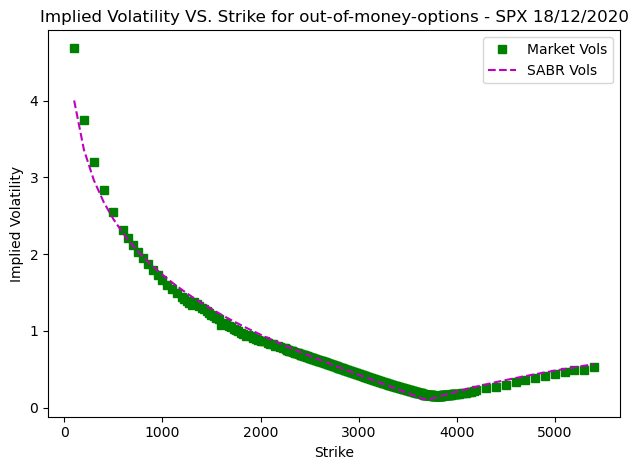

In [44]:
beta = 0.7
strikes = spx1_put['strike'].values
impliedvols = []
for K in strikes:
    if K > S_spx:
        impliedvols.append(spx1_call[spx1_call['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(spx1_put[spx1_put['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
plot_df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              plot_df['strike'],
                                              plot_df['impliedvol'],
                                              F_spx[0],
                                              T_SPX[0]),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols = []
for K in strikes:
    sabrvols.append(SABR(F_spx[0], K, T_SPX[0], alpha, beta, rho, nu))

plt.figure(tight_layout=True)
plt.plot(strikes, plot_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.title("Implied Volatility VS. Strike for out-of-money-options - SPX 18/12/2020")
plt.ylabel("Implied Volatility")
plt.xlabel("Strike")
plt.legend()
plt.show()

## SPX DATE2: 15-01-2021

Calibrated SABR model parameters: alpha = 1.821, beta = 0.7, rho = -0.407, nu = 2.788


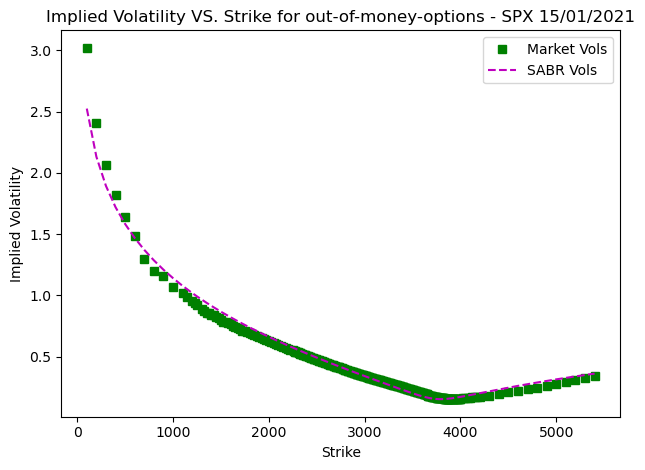

In [46]:
beta = 0.7
strikes = spx2_put['strike'].values
impliedvols = []
for K in strikes:
    if K > S_spx:
        impliedvols.append(spx2_call[spx2_call['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(spx2_put[spx2_put['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
plot_df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              plot_df['strike'],
                                              plot_df['impliedvol'],
                                              F_spx[1],
                                              T_SPX[1]),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols = []
for K in strikes:
    sabrvols.append(SABR(F_spx[1], K, T_SPX[1], alpha, beta, rho, nu))

plt.figure(tight_layout=True)
plt.plot(strikes, plot_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.title("Implied Volatility VS. Strike for out-of-money-options - SPX 15/01/2021")
plt.ylabel("Implied Volatility")
plt.xlabel("Strike")
plt.legend()
plt.show()

## SPX DATE3: 19-02-2021

Calibrated SABR model parameters: alpha = 2.168, beta = 0.7, rho = -0.579, nu = 1.854


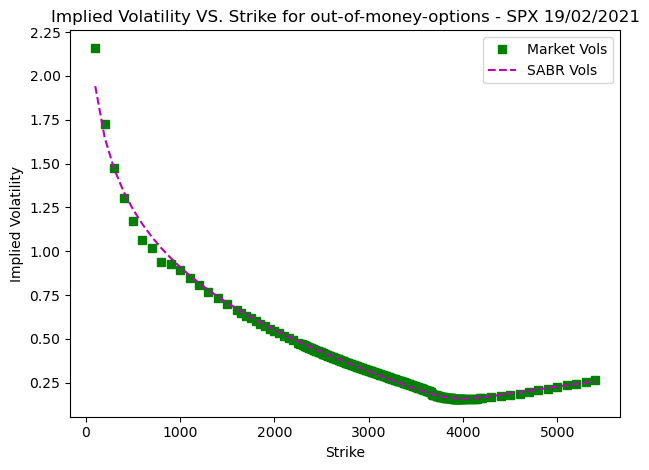

In [48]:
beta = 0.7
strikes = spx3_put['strike'].values
impliedvols = []
for K in strikes:
    if K > S_spx:
        impliedvols.append(spx3_call[spx3_call['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(spx3_put[spx3_put['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
plot_df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              plot_df['strike'],
                                              plot_df['impliedvol'],
                                              F_spx[1],
                                              T_SPX[1]),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols = []
for K in strikes:
    sabrvols.append(SABR(F_spx[1], K, T_SPX[1], alpha, beta, rho, nu))

plt.figure(tight_layout=True)
plt.plot(strikes, plot_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.title("Implied Volatility VS. Strike for out-of-money-options - SPX 19/02/2021")
plt.ylabel("Implied Volatility")
plt.xlabel("Strike")
plt.legend()
plt.show()

# 2B. Plotting for SPY for each of the 3 expiry dates

In [50]:
### 2B Step 1. Filter for SPX options to use for plotting and calibration
## SPY Options for Each Maturity

spy1 = spy_df[(spy_df.exdate == 20201218)]
spy2 = spy_df[(spy_df.exdate == 20210115)]
spy3 = spy_df[(spy_df.exdate == 20210219)]

## SPY calls & puts
spy1_call = spy1[(spy1.payoff == 'call')]
spy1_put = spy1[(spy1.payoff == 'put')]
spy2_call = spy2[(spy2.payoff == 'call')]
spy2_put = spy2[(spy2.payoff == 'put')]
spy3_call = spy3[(spy3.payoff == 'call')]
spy3_put = spy3[(spy3.payoff == 'put')]

## SPY DATE1: 18-12-2020

Calibrated SABR model parameters: alpha = 0.666, beta = 0.7, rho = -0.413, nu = 5.248


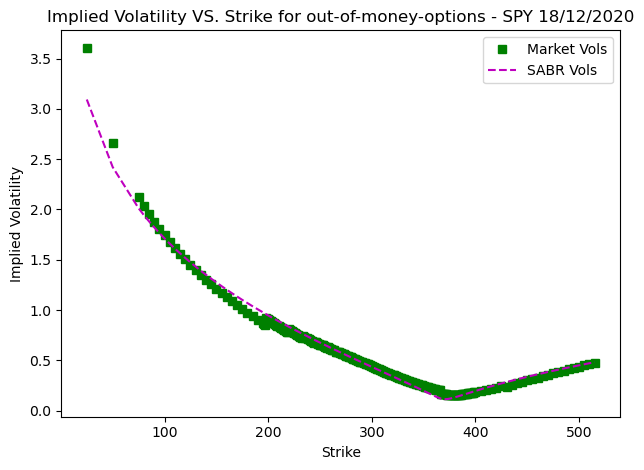

In [52]:
beta = 0.7
strikes = spy1_put['strike'].values
impliedvols = []
for K in strikes:
    if K > S_spy:
        impliedvols.append(spy1_call[spy1_call['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(spy1_put[spy1_put['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
plot_df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              plot_df['strike'],
                                              plot_df['impliedvol'],
                                              F_spy[0],
                                              T_SPY[0]),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols = []
for K in strikes:
    sabrvols.append(SABR(F_spy[0], K, T_SPY[0], alpha, beta, rho, nu))

plt.figure(tight_layout=True)
plt.plot(strikes, plot_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.title("Implied Volatility VS. Strike for out-of-money-options - SPY 18/12/2020")
plt.ylabel("Implied Volatility")
plt.xlabel("Strike")
### put title here for (Implied Volatility against Strike for out-of-money-options, date 20201218)
plt.legend()
plt.show()

## SPY DATE2: 15-01-2021

Calibrated SABR model parameters: alpha = 0.910, beta = 0.7, rho = -0.491, nu = 2.726


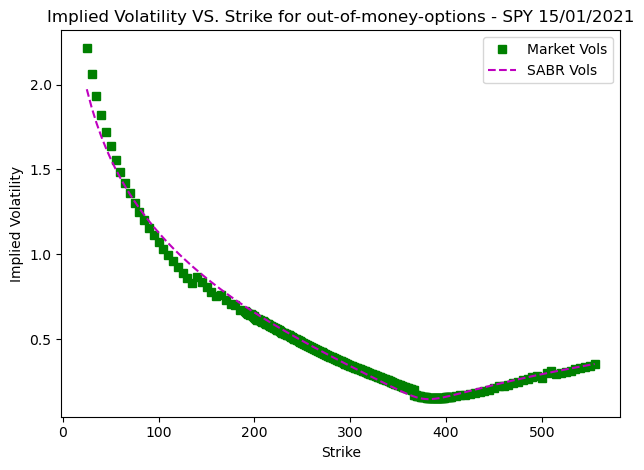

In [54]:
beta = 0.7
strikes = spy2_put['strike'].values
impliedvols = []
for K in strikes:
    if K > S_spy:
        impliedvols.append(spy2_call[spy2_call['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(spy2_put[spy2_put['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
plot_df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              plot_df['strike'],
                                              plot_df['impliedvol'],
                                              F_spy[1],
                                              T_SPY[1]),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols = []
for K in strikes:
    sabrvols.append(SABR(F_spy[1], K, T_SPY[1], alpha, beta, rho, nu))

plt.figure(tight_layout=True)
plt.plot(strikes, plot_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.title("Implied Volatility VS. Strike for out-of-money-options - SPY 15/01/2021")
plt.ylabel("Implied Volatility")
plt.xlabel("Strike")
plt.legend()
plt.show()

## SPY DATE3: 19-02-2021

Calibrated SABR model parameters: alpha = 1.124, beta = 0.7, rho = -0.636, nu = 1.740


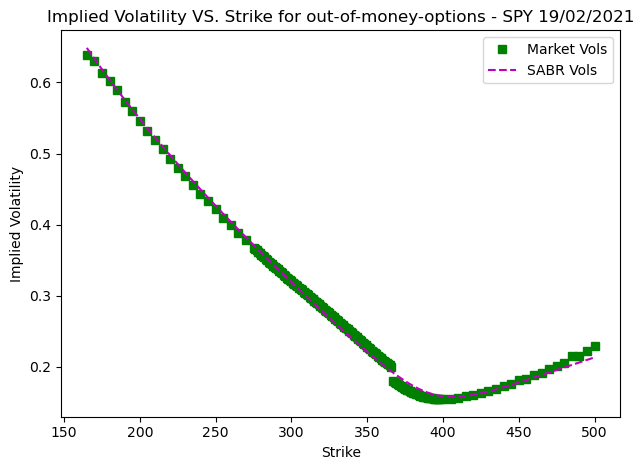

In [56]:
beta = 0.7
strikes = spy3_put['strike'].values
impliedvols = []
for K in strikes:
    if K > S_spy:
        impliedvols.append(spy3_call[spy3_call['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(spy3_put[spy3_put['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
plot_df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              plot_df['strike'],
                                              plot_df['impliedvol'],
                                              F_spy[2],
                                              T_SPY[2]),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols = []
for K in strikes:
    sabrvols.append(SABR(F_spy[2], K, T_SPY[2], alpha, beta, rho, nu))

plt.figure(tight_layout=True)
plt.plot(strikes, plot_df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.title("Implied Volatility VS. Strike for out-of-money-options - SPY 19/02/2021")
plt.ylabel("Implied Volatility")
plt.xlabel("Strike")
plt.legend()
plt.show()